# Lazy-abstraction-reachability


This is a **optimal reachability problem** for a **continuous system**.


In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$.

The abstraction is based on a feedback refinment relation [1,V.2 Definition].
This allows to easily determine the controller of the concrete system from the abstraction controller by simply adding a quantization step.

For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the used of a growth bound function  [1, VIII.2, VIII.5] which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center. Therefore, it is used
to compute the relations in the abstraction based on the feedback refinement relation.

For this reachability problem, the abstraction controller is built using a solver that lazily builds the abstraction, constructing the abstraction
at the same time as the controller.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots].

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const CO = DI.Control
const SY = DI.Symbolic
const LA = DI.Control.LazyAbstractionReach

# specific functions
function post_image(symmodel, contsys, xpos, u)
    Xdom = symmodel.Xdom
    x = DO.get_coord_by_pos(Xdom.grid, xpos)
    tstep = contsys.tstep
    Fx = contsys.sys_map(x, u, tstep)
    r = Xdom.grid.h / 2.0 + contsys.measnoise
    Fr = r

    rectI = DO.get_pos_lims_outer(Xdom.grid, UT.HyperRectangle(Fx .- Fr, Fx .+ Fr))
    ypos_iter = Iterators.product(DO._ranges(rectI)...)
    over_approx = []
    allin = true
    for ypos in ypos_iter
        ypos = DO.set_in_period_pos(Xdom, ypos)
        if !(ypos in Xdom)
            allin = false
            break
        end
        target = SY.get_state_by_xpos(symmodel, ypos)[1]
        push!(over_approx, target)
    end
    return allin ? over_approx : []
end

function pre_image(symmodel, contsys, xpos, u)
    grid = symmodel.Xdom.grid
    x = DO.get_coord_by_pos(grid, xpos)
    tstep = contsys.tstep
    potential = Int[]
    x_prev = x - tstep * u
    xpos_cell = DO.get_pos_by_coord(grid, x_prev)
    n = 2
    for i in (-n):n
        for j in (-n):n
            x_n = (xpos_cell[1] + i, xpos_cell[2] + j)
            x_n = DO.set_in_period_pos(symmodel.Xdom, x_n)
            if x_n in symmodel.Xdom
                cell = SY.get_state_by_xpos(symmodel, x_n)[1]
                if !(cell in potential)
                    push!(potential, cell)
                end
            end
        end
    end
    return potential
end

function compute_reachable_set(rect::UT.HyperRectangle, contsys, Udom)
    tstep = contsys.tstep
    r = (rect.ub - rect.lb) / 2.0 + contsys.measnoise
    Fr = r
    x = UT.get_center(rect)
    n = UT.get_dims(rect)
    lb = fill(Inf, n)
    ub = fill(-Inf, n)
    for upos in DO.enum_pos(Udom)
        u = DO.get_coord_by_pos(Udom.grid, upos)
        Fx = contsys.sys_map(x, u, tstep)
        lb = min.(lb, Fx .- Fr)
        ub = max.(ub, Fx .+ Fr)
    end
    lb = SVector{n}(lb)
    ub = SVector{n}(ub)
    return UT.HyperRectangle(lb, ub)
end

function get_transitions(symmodel, sys, source)
    return SY.get_transitions_1(symmodel, sys, source, compute_reachable_set)
end

function minimum_transition_cost(symmodel, contsys, source, target)
    return 1.0
end

# problem data
struct SimpleSystem{N, T, F <: Function} <: ST.ControlSystem{N, T}
    tstep::Float64
    measnoise::SVector{N, T}
    sys_map::F
end

function NewSimpleSystem(tstep, measnoise::SVector{N, T}) where {N, T}
    function sys_map(x::SVector{N, T}, u, tstep)
        return x + tstep * u
    end
    return SimpleSystem(tstep, measnoise, sys_map)
end

function build_system()
    tstep = 0.8
    measnoise = SVector(0.0, 0.0)
    return NewSimpleSystem(tstep, measnoise)
end

function build_dom()
    X = UT.HyperRectangle(SVector(0.0, 0.0), SVector(30.0, 30.0))
    obstacle = UT.HyperRectangle(SVector(15.0, 15.0), SVector(20.0, 20.0))
    hx = [0.5, 0.5]
    periodic = Int[]
    periods = [30.0, 30.0]
    T0 = [0.0, 0.0]
    grid = DO.build_grid_in_rec(X, hx)
    d = DO.RectangularObstacles(X, [obstacle])
    Xdom =
        DO.GeneralDomainList(hx; elems = d, periodic = periodic, periods = periods, T0 = T0)
    fig = plot(; aspect_ratio = 1)
    return X, Xdom
end

function build_Udom()
    U = UT.HyperRectangle(SVector(-2.0, -2.0), SVector(2.0, 2.0))
    x0 = SVector(0.0, 0.0)
    hu = SVector(0.5, 0.5)
    Ugrid = DO.GridFree(x0, hu)
    Udom = DO.DomainList(Ugrid)
    DO.add_set!(Udom, U, DO.OUTER)
    box = UT.HyperRectangle(SVector(-0.5, -0.5), SVector(0.5, 0.5))
    DO.remove_set!(Udom, box, DO.OUTER)
    return Udom
end

function transition_cost(x, u)
    return 0.5
end

function h1(node::UT.Node, problem::LA.LazyAbstraction)
    source = node.state.source
    symmodel = problem.symmodel
    xpos = SY.get_xpos_by_state(symmodel, source)
    x = DO.get_coord_by_pos(symmodel.Xdom.grid, xpos)

    heuristic = problem.heuristic_data
    symmodel2 = heuristic.symmodel
    xpos2 = DO.get_pos_by_coord(symmodel2.Xdom.grid, x)
    source2 = SY.get_state_by_xpos(symmodel2, xpos2)[1]
    return heuristic.dists[source2]
end

function build_heuristic_data(X, contsys, Udom, _I_)
    hx = [1.0, 1.0] * 1.5
    periodic = Int[]
    periods = [30.0, 30.0]
    T0 = [0.0, 0.0]
    Xdom = DO.GeneralDomainList(hx; periodic = periodic, periods = periods, T0 = T0)
    DO.add_set!(Xdom, X, DO.OUTER)
    symmodel = SY.symmodelAS(Xdom, Udom, contsys, minimum_transition_cost, get_transitions)
    initlist = SY.get_symbol(symmodel, _I_, DO.OUTER)
    heuristic_data = SY.build_heuristic(symmodel, initlist)
    return heuristic_data
end

build_heuristic_data (generic function with 1 method)

Define the domains

In [3]:
X, Xdom = build_dom()
Udom = build_Udom();

Define the system

In [4]:
contsys = build_system();

Define the specifications

In [5]:
_I_ = UT.HyperRectangle(SVector(5.0, 5.0), SVector(6.0, 6.0))
_T_ = UT.HyperRectangle(SVector(25.0, 25.0), SVector(28.0, 28.0));

Construct the heuristic to guide the A* exploration

In [6]:
heuristic_data = build_heuristic_data(X, contsys, Udom, _I_);

Define the symbolic model and the abstract specifications

In [7]:
symmodel = SY.LazySymbolicModel(Xdom, Udom)
initlist = SY.get_symbol(symmodel, _I_, DO.OUTER)
targetlist = SY.get_symbol(symmodel, _T_, DO.INNER);

Solve the abstract problem

In [8]:
problem, sucess = LA.compute_controller(
    symmodel,
    contsys,
    initlist,
    targetlist,
    transition_cost,
    pre_image,
    post_image,
    h1;
    heuristic_data = heuristic_data,
)
contr = problem.contr;


number of transitions created: 227090
compute_controller_reach! terminated with success


Display a trajectory


Plotting


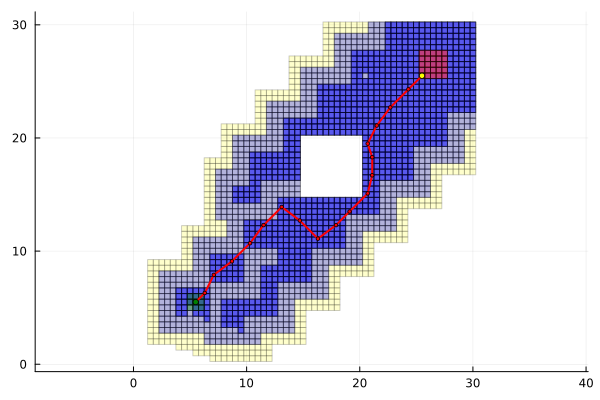

In [9]:
fig = plot(; aspect_ratio = :equal)
x0 = SVector(5.5, 5.5)
LA.plot_result!(problem; x0 = x0)
plot!(; show = true, legend = false)

### References
1. G. Reissig, A. Weber and M. Rungger, "Feedback Refinement Relations for the Synthesis of Symbolic Controllers," in IEEE Transactions on Automatic Control, vol. 62, no. 4, pp. 1781-1796.
2. K. J. Aström and R. M. Murray, Feedback systems. Princeton University Press, Princeton, NJ, 2008.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*